## 安裝 gym

In [ ]:
!pip install 'gym[all]'

## 列出OpenAI Gym中所有的環境

In [ ]:
from gym import envs

# envs.registry.all()

## 在OpenAI Gym中創建環境

In [ ]:
import gym
env = gym.make("CartPole-v0") #創建一個新環境，命名為env

## 在Cartpole中執行動作

In [ ]:
state1 = env.reset() #初始化環境
action = env.action_space.sample() #利用sample()隨機從動作空間中取得一個動作
state, reward, done, info = env.step(action) #利用step()執行所選擇的動作，並傳回狀態資料

## 建構策略網路模型

In [ ]:
import gym
import numpy as np
import torch
 
L1 = 4 #輸入資料的向量長度
L2 = 150 #隱藏層會輸出長度為150的向量
L3 = 2 #策略網路所輸出的向量長度

model = torch.nn.Sequential(
    torch.nn.Linear(L1, L2), #隱藏層的shape為（L1,L2)
    torch.nn.LeakyReLU(),
    torch.nn.Linear(L2, L3), #輸出層的shape為（L2,L3)
    torch.nn.Softmax(dim=0)   #用softmax()將動作價值轉換成機率
)
learning_rate = 0.009
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)	

## 使用策略網路來進行隨機動作選擇

In [ ]:
pred = model(torch.from_numpy(state1).float()) #呼叫策略網路模型以產生各動作的機率分佈（命名為pred)
action = np.random.choice(np.array([0,1]), p=pred.data.numpy()) #根據策略網路輸出的機率分佈pred來隨機選取動作
state2, reward, done, info = env.step(action) #執行動作並記錄不同資料

## 計算折扣回報值

In [ ]:
def discount_rewards(rewards, gamma=0.99):
    lenr = len(rewards) #計算遊戲進行了幾步
    disc_return = torch.pow(gamma,torch.arange(lenr).float()) * rewards #計算呈指數方式下降的折扣回報陣列
    disc_return /= disc_return.max() #正規化以上的陣列，使其元素的值落在 [0,1]
    return disc_return 

## 定義損失函數

In [ ]:
def loss_fn(preds, r): #損失函數的輸入參數為：折扣回報陣列以及機率陣列
    return -1 * torch.sum(r * torch.log(preds))

## REINFORCE演算法的訓練迴圈

In [ ]:
MAX_DUR = 200 #每場遊戲的最大步數
MAX_EPISODES = 500 #訓練的遊戲次數
gamma = 0.99
score = [] #創立一個串列來記錄每場遊戲的長度

for episode in range(MAX_EPISODES):
    curr_state = env.reset()
    done = False
    transitions = [] #使用串列記錄狀態、動作、回饋值（即經驗）    
    for t in range(MAX_DUR):
        act_prob = model(torch.from_numpy(curr_state).float()) #用模型預測各動作的機率分佈
        action = np.random.choice(np.array([0,1]), p=act_prob.data.numpy()) #參照機率分佈隨機選擇一個動作
        prev_state = curr_state
        curr_state, _, done, info = env.step(action) #在環境中執行動作，並取得新狀態以及是否結束的訊息
        transitions.append((prev_state, action, t+1)) #將當前狀態的資料記錄下來（編註：每一輪遊戲後，會把回饋值遞增並存進串列，接下來會將這個串列反轉 (由遞增改為遞減排列) 為回報張量）
        if done: #如果輸掉了遊戲，就跳出迴圈 
            break
    ep_len = len(transitions) #取得整場遊戲的長度
    score.append(ep_len)
    reward_batch = torch.Tensor([r for (s,a,r) in transitions]).flip(dims=(0,)) #將整場遊戲中的所有回饋值記錄到一個張量中，flip()可將指定階 (第0階) 中的元素進行反轉 (前後順序對調)
    disc_returns = discount_rewards(reward_batch) #計算折扣回報陣列
    state_batch = torch.Tensor([s for (s,a,r) in transitions]) #將整場遊戲中的所有狀態記錄到一個張量中
    action_batch = torch.Tensor([a for (s,a,r) in transitions]) #將整場遊戲中執行過的所有動作記錄到一個張量中
    pred_batch = model(state_batch) #重新計算所有狀態下各動作的機率分佈
    prob_batch = pred_batch.gather(dim=1,index=action_batch.long().unsqueeze(dim=1)).squeeze() #找出所執行動作對應到的機率值
    loss = loss_fn(prob_batch, disc_returns)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)


## 計算移動平均值

In [ ]:
def running_mean(x, N=50):
    kernel = np.ones(N)
    conv_len = x.shape[0]-N
    y = np.zeros(conv_len)
    for i in range(conv_len):
        y[i] = kernel @ x[i:i+N]
        y[i] /= N
    return y

## 將移動平均值畫成圖形

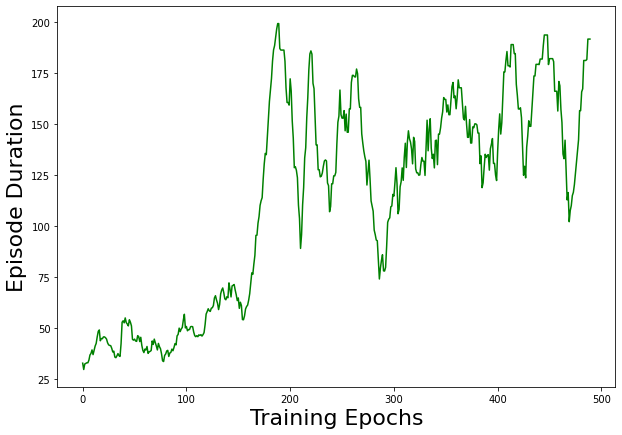

In [ ]:
import matplotlib.pyplot as plt
score = np.array(score)
avg_score = running_mean(score, 10)

plt.figure(figsize=(10,7))
plt.ylabel("Episode Duration",fontsize=22)
plt.xlabel("Training Epochs",fontsize=22)
plt.plot(avg_score, color='green')